<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-датасета" data-toc-modified-id="Подготовка-датасета-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка датасета</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Стандартизация-числовых-признаков-(StandardScaler)" data-toc-modified-id="Стандартизация-числовых-признаков-(StandardScaler)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Стандартизация числовых признаков (StandardScaler)</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-DecisionTreeRergessor" data-toc-modified-id="Модель-DecisionTreeRergessor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Модель DecisionTreeRergessor</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод-по-проекту" data-toc-modified-id="Вывод-по-проекту-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод по проекту</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df = df.resample('1H').sum()

## Анализ

In [4]:
df.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


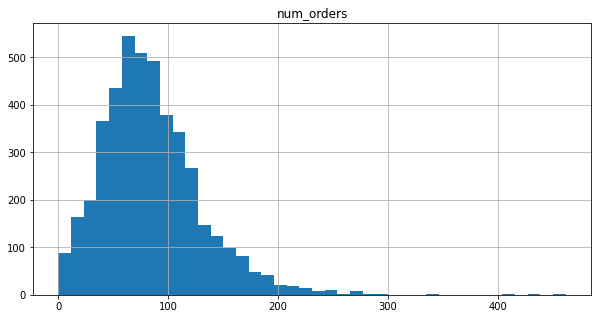

In [6]:
df.hist(figsize = (10,5), bins = 40);

In [7]:
df.isna().sum()

num_orders    0
dtype: int64

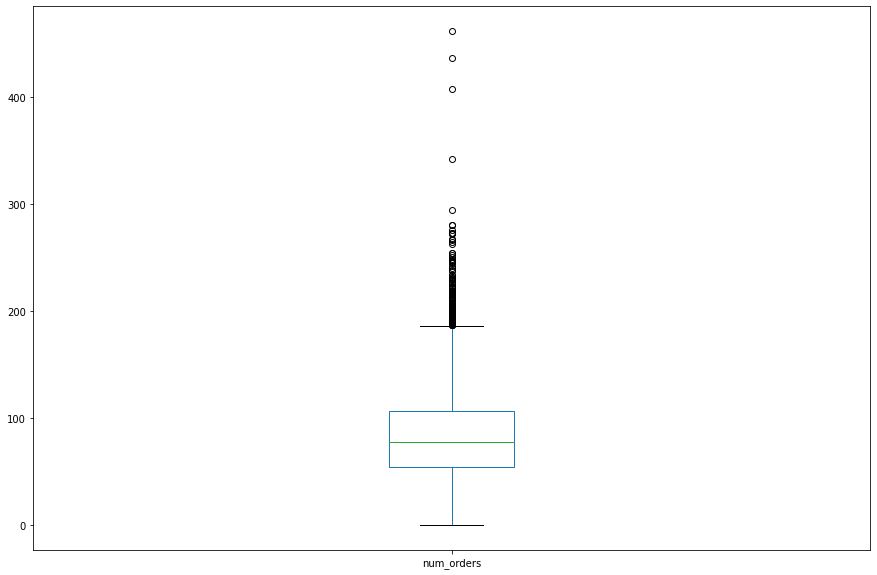

In [8]:
df.plot(kind = 'box', figsize = (15,10));

**Теперь попробуем отследить динамику заказов такси, проверим тренды и сезонность**

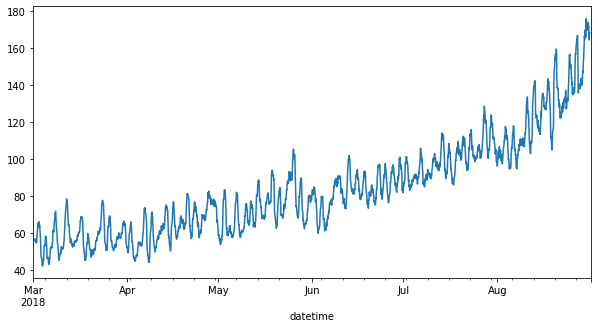

In [9]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(figsize = (10,5));

**Видим, что тренд восходящий, то есть заказы растут с каждым месяцем. Теперь посмотрим на сезонность**

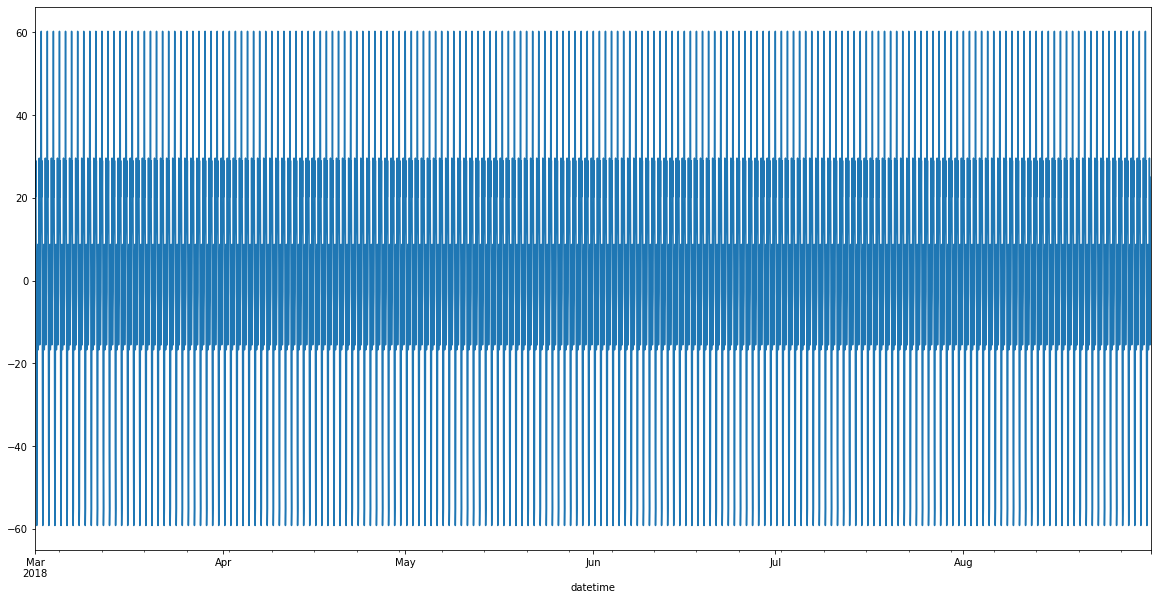

In [10]:
decomposed.seasonal.plot(figsize = (20,10));

**Для определения сезонности данные слишком сильно варьируются. Теперь посмотрим на динамику в течение одного дня**

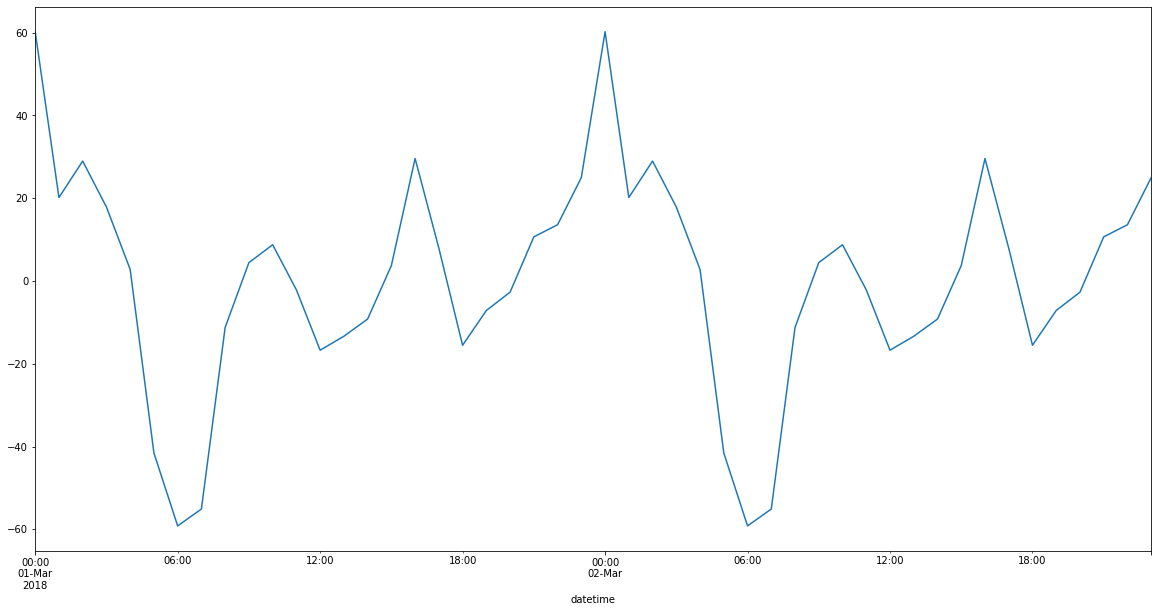

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize = (20,10));

**Видно, что больше всего такси вызывают днем (в районе 17 часов) и ночью (около 00:00)**

**Вывод по анализу:**
* В датасете присутствует 4416 значений типа *int64*
* Среднее по заказам 84. Значения варьируются от 0 до 462
* В датасете присутствуют выбросы и дубликаты
* Пропусков не обнаружено
* Отследили тренд, сезонность и динамику в течение дня:
    1. Тренд восходящий, заказы такси растут с каждым месяцем
    2. Сезонности нет ввиду сильного колебания значений
    3. В течение дня большинство заказов приходится на ночь и на ранний вечер около 17:00


**Бонус: определяем стационарность временного ряда тестом Дики-Фуллера:**

In [12]:
result = adfuller(df)
print('ADF Statistics:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistics: -3.0689242890279558
p-value: 0.028940051402612906
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


**p-value** меньше заданного уровня значимости 0.05, значит не принимаем гипотезу о нестационарности ряда. Соответственно, ряд можно считать стационарным и сделать вывод, что сезонности нет

## Обучение

### Подготовка датасета

Подготовка датасета необходима для того, чтобы создать признаки, по которым модель будет обучаться предсказывать количество заказов такси. Для этого напишем функцию **make_features**, которая на вход будет получать: датасет, максимальный размер отставания и окно для скользящей средней

In [13]:
def make_features(df, max_lag, rolling_mean_size): 
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['MA'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [14]:
make_features(df,24,15)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,MA
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,156.133333
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,147.333333
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,152.400000


### Разделение на выборки

Разделим исходный датасет на тренировочную и тестовую выборки в соотношении 9:1

In [15]:
train, test = train_test_split(df, test_size = 0.1, shuffle = False)

In [16]:
train = train.dropna()

In [17]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

### Стандартизация числовых признаков (StandardScaler)

In [18]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

## Обучение моделей

### Модель LinearRegression

In [19]:
ts_cv = TimeSeriesSplit(n_splits = 3)

In [20]:
params = {'fit_intercept':[True,False],
          'normalize':[True,False],
          'copy_X':[True, False]
}

grid_lr = GridSearchCV(LinearRegression(), params, cv = ts_cv, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_lr.fit(features_train_scaled, target_train)
print(-grid_lr.best_score_)

27.734691017809542


### Модель DecisionTreeRergessor

In [22]:
params = {"criterion": ['mse'],
              "min_samples_split": [2, 5, 10],
              "max_depth": [2, 4, 10],
              "min_samples_leaf": [2, 4, 6],
              }

grid_dtr = GridSearchCV(DecisionTreeRegressor(), params, cv = ts_cv,
                        scoring = 'neg_root_mean_squared_error', n_jobs = 1)
grid_dtr.fit(features_train, target_train)

print(-grid_dtr.best_score_)

31.678889795651227


### Random Forest Regressor

In [23]:
params = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [1,2,3,4]
}
grid_rfs = GridSearchCV(RandomForestRegressor(random_state = 12345), params, cv = ts_cv,
                                              n_jobs = -1, scoring = 'neg_root_mean_squared_error')
grid_rfs.fit(features_train, target_train)

print(-grid_rfs.best_score_)

30.233613688001242


In [24]:
grid_lr.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

**Лучшая метрика RMSE на модели LinearRegression: RMSE = 27. Проверим эту модель на тестовой выборке**

## Тестирование

In [25]:
mean_squared_error(grid_lr.predict(features_test_scaled), target_test)**0.5

44.98369119885845

## Вывод по проекту

* Выполнили загрузку датасета и проанализировали данные:   
    1. В данных нет пропусков, 
    2. Тренд восходящий, но сезонности нету. В течение дня количество заказов такси максимальное ночью и в районе 17 часов вечера
    3. В датасете присутствует 4416 значений типа *int64*
    4. Среднее по заказам 84. Значения варьируются от 0 до 462
* Написали функцию **make_features**, которая создает признаки в датасете, по которым модель будет обучаться
* Разделили выборки на тренировочную и тестовую в соотношении 9:1. 
* Обучили три модели: **LinearRegression, DecisionTreeRegressor, RandomForestRegressor**
* Лучшая метрика **RMSE** на тренировочной выборке у модели **RandomForestRegressor** (25), на тестовой –– у  модели **LinearRegression (45)**